# Loading Required Libraries

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Data Reading 

import os
from glob import glob
from PIL import Image

# Data Processing 

import numpy as np
import pandas as pd
import cv2
import random
import albumentations as A

# Data Analysis

import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

# Data Modeling & Model Evaluation

from sklearn.model_selection import train_test_split
from keras.preprocessing import image
from tensorflow.keras import layers, models
import tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, recall_score, accuracy_score, precision_score, f1_score

# Grad-CAM

import keras
import matplotlib.cm as cm

# Reading the data

In [2]:
levels = ['0', '1']
path = "Sperm-Data/all_data"
data_dir = os.path.join(path)

data = []
for id, level in enumerate(levels):
    for file in os.listdir(os.path.join(data_dir, level)):
        data.append(['{}/{}'.format(level, file), level])

data = pd.DataFrame(data, columns = ['image_file', 'Sperm_Results'])

data['path'] = path + '/' + data['image_file']
data['Sperm_Results'] = data['Sperm_Results'].map({'0': 'Normal', '1': 'Abnormal'})

data.head()


image_file Sperm_Results  \
0   0/2017a_99_199_11423_1815.png        Normal   
1  0/2017a_99_199_17804_18574.png        Normal   
2    0/2017a_99_199_2113_7597.png        Normal   
3  0/2017a_99_199_23146_23873.png        Normal   
4   0/2017a_99_99_17335_12430.png        Normal   

                                                path  
0  Sperm-Data/all_data/0/2017a_99_199_11423_1815.png  
1  Sperm-Data/all_data/0/2017a_99_199_17804_18574...  
2   Sperm-Data/all_data/0/2017a_99_199_2113_7597.png  
3  Sperm-Data/all_data/0/2017a_99_199_23146_23873...  
4  Sperm-Data/all_data/0/2017a_99_99_17335_12430.png

In [3]:
print('Number of Duplicated Samples: %d'%(data.duplicated().sum()))
print('Number of Total Samples: %d'%(data.isnull().value_counts()))

Number of Duplicated Samples: 0
Number of Total Samples: 986


# Exploratory Data Analysis

1. Count Plot

In [4]:
df = pd.DataFrame()
df['Sperm_Results'] = ['Normal', 'Abnormal']
df['Sperm_Count'] = [len(data[data['Sperm_Results'] == 'Normal']), len(data[data['Sperm_Results'] == 'Abnormal'])]
df = df.sort_values(by = ['Sperm_Count'], ascending = False)

fig = px.bar(df, x = 'Sperm_Results', y = 'Sperm_Count', 
             color = "Sperm_Results", text_auto='', width = 600, 
             color_discrete_sequence = ["green", "red"],
             template = 'plotly_dark')

fig.update_xaxes(showgrid = False)
fig.update_yaxes(showgrid = False)
fig.update_traces(textfont_size = 12, textangle = 0, textposition = "outside", cliponaxis = False)

fig.show()

2. Image Samples

In [5]:
data['image'] = data['path'].map(lambda x: np.asarray(Image.open(x).resize((128,128))))

data.head()

image_file Sperm_Results  \
0   0/2017a_99_199_11423_1815.png        Normal   
1  0/2017a_99_199_17804_18574.png        Normal   
2    0/2017a_99_199_2113_7597.png        Normal   
3  0/2017a_99_199_23146_23873.png        Normal   
4   0/2017a_99_99_17335_12430.png        Normal   

                                                path  \
0  Sperm-Data/all_data/0/2017a_99_199_11423_1815.png   
1  Sperm-Data/all_data/0/2017a_99_199_17804_18574...   
2   Sperm-Data/all_data/0/2017a_99_199_2113_7597.png   
3  Sperm-Data/all_data/0/2017a_99_199_23146_23873...   
4  Sperm-Data/all_data/0/2017a_99_99_17335_12430.png   

                                               image  
0  [[[215, 217, 217], [215, 217, 217], [222, 216,...  
1  [[[218, 190, 209], [218, 195, 210], [217, 199,...  
2  [[[223, 204, 221], [223, 204, 221], [223, 204,...  
3  [[[220, 214, 219], [222, 216, 221], [221, 215,...  
4  [[[218, 212, 217], [219, 213, 218], [221, 215,...

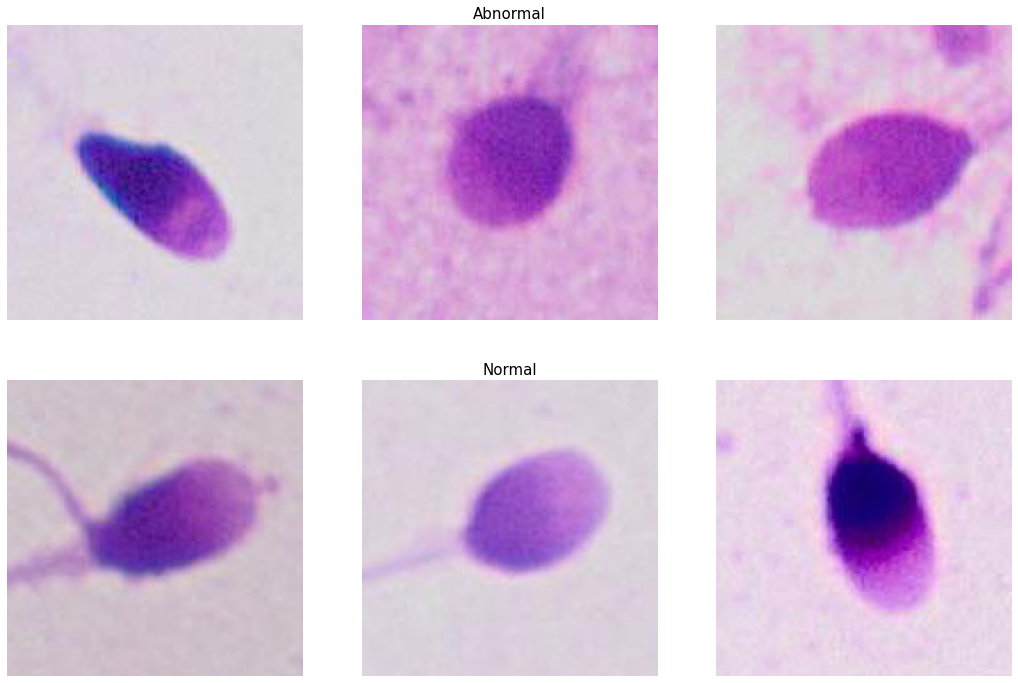

In [6]:
n_samples = 3

fig, m_axs = plt.subplots(2, n_samples, figsize = (6*n_samples, 3*4))

for n_axs, (type_name, type_rows) in zip(m_axs, data.sort_values(['Sperm_Results']).groupby('Sperm_Results')):
    n_axs[1].set_title(type_name, fontsize = 15)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state = 1234).iterrows()):       
        picture = c_row['path']
        image = cv2.imread(picture)
        c_ax.imshow(image)
        c_ax.axis('off')

3. Random Image Analysis

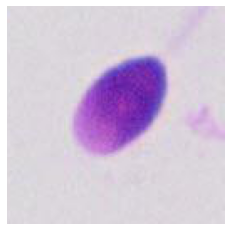

In [7]:
plt.figure()
image = cv2.imread("Sperm-Data/all_data/0/2017a_99_199_11423_1815.png")
plt.imshow(image)
plt.axis('off')
plt.show() 

In [8]:
print('Image Shape: {}'.format(image.shape))
print('Image Height: {}'.format(image.shape[0]))
print('Image Width: {}'.format(image.shape[1]))
print('Image Dimension: {}'.format(image.ndim))
print('Image Size: {}kb'.format(image.size//1024))
print('Image Data Type: {}'.format(image.dtype))
print('Maximum RGB value of the image: {}'.format(image.max()))
print('Minimum RGB value of the image: {}'.format(image.min()))

Image Shape: (130, 130, 3)
Image Height: 130
Image Width: 130
Image Dimension: 3
Image Size: 49kb
Image Data Type: uint8
Maximum RGB value of the image: 244
Minimum RGB value of the image: 24


I observe that the image has 3 channels, hence it in in RGB scale even if these are sperm images.

4. B-Channel

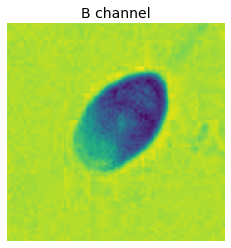

In [9]:
plt.title('B channel', fontsize = 14)
plt.imshow(image[ : , : , 0])
plt.axis('off');
plt.show()

5. Ben Graham's Method

First, I convert the images to greyscale and then apply Gaussian blur to them.

In [10]:
all_abnormal = []
all_normal = []

all_normal.extend(glob(os.path.join(path, "0/*.png")))
all_abnormal.extend(glob(os.path.join(path, "1/*.png")))

random.shuffle(all_normal)
random.shuffle(all_abnormal)

images = all_normal[:50] + all_abnormal[:50]

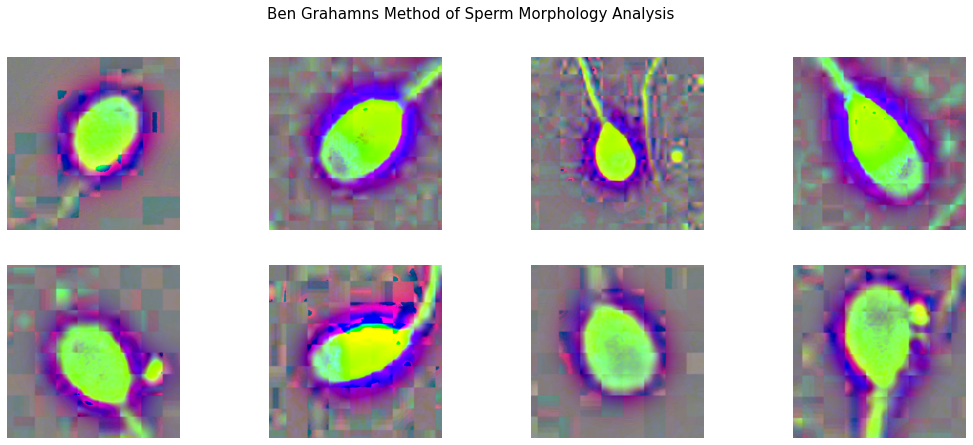

In [11]:
fig = plt.figure(figsize = (18, 7))
fig.suptitle("Ben Grahamns Method of Sperm Morphology Analysis", fontsize = 15)
columns = 4; rows = 2

for i in range(1, columns*rows +1):
    img = cv2.imread(images[i])
    img = cv2.resize(img, (512, 512))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    img = cv2.addWeighted (img, 4, cv2.GaussianBlur(img, (0,0), 512/10), -4, 128)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    plt.axis(False)

6. Albumentations Visualization

In [12]:
def plot_multiple_img(img_matrix_list, title_list, ncols, main_title = ""):
    
    fig, myaxes = plt.subplots(figsize = (15, 8), nrows = 2, ncols = ncols, squeeze = False)
    fig.suptitle(main_title, fontsize = 18)
    fig.subplots_adjust(wspace = 0.3)
    fig.subplots_adjust(hspace = 0.3)
    
    for i, (img, title) in enumerate(zip(img_matrix_list, title_list)):
        myaxes[i // ncols][i % ncols].imshow(img)
        myaxes[i // ncols][i % ncols].set_title(title, fontsize = 15)
        
    plt.show()

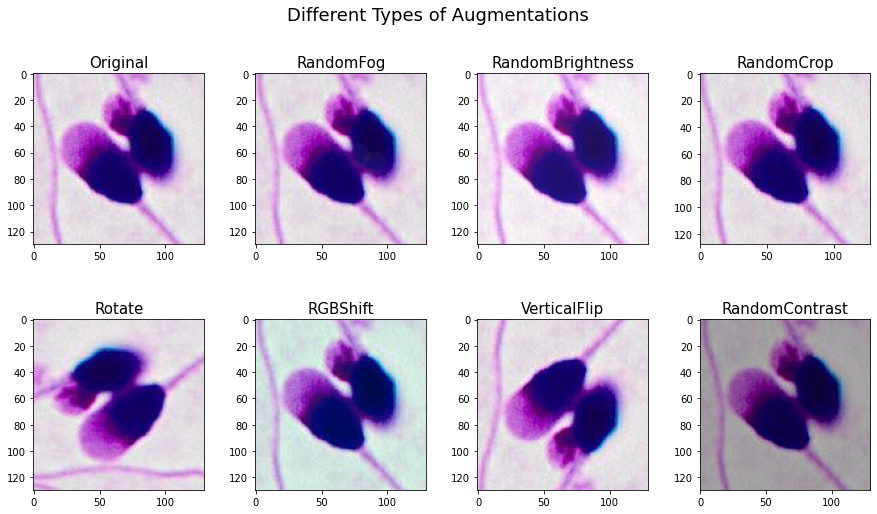

In [13]:
chosen_image = cv2.imread("Sperm-Data/all_data/0/s22016b_399_199_15256_9313.png")

albumentation_list = [A.RandomFog(p = 1), A.RandomBrightness(p = 1),
                      A.RandomCrop(p = 1,height = 128, width = 128), A.Rotate(p = 1, limit = 90),
                      A.RGBShift(p = 1), A.VerticalFlip(p = 1), A.RandomContrast(limit = 0.5, p = 1)]

img_matrix_list = []
bboxes_list = []
for aug_type in albumentation_list:
    img = aug_type(image = chosen_image)['image']
    img_matrix_list.append(img)

img_matrix_list.insert(0,chosen_image)    

titles_list = ["Original", "RandomFog", "RandomBrightness", "RandomCrop", "Rotate", "RGBShift", "VerticalFlip", "RandomContrast"]

plot_multiple_img(img_matrix_list, titles_list, ncols = 4, main_title = "Different Types of Augmentations")


7. Image Value Distribution

In [14]:
mean_val = []
std_dev_val = []
max_val = []
min_val = []
samples = 986

for i in range(0, samples):
    mean_val.append(data['image'][i].mean())
    std_dev_val.append(np.std(data['image'][i]))
    max_val.append(data['image'][i].max())
    min_val.append(data['image'][i].min())

imageEDA = data.loc[:,['image','Sperm_Results','path']]
imageEDA['mean'] = mean_val
imageEDA['stedev'] = std_dev_val
imageEDA['max'] = max_val
imageEDA['min'] = min_val

imageEDA['subt_mean'] = imageEDA['mean'].mean() - imageEDA['mean']

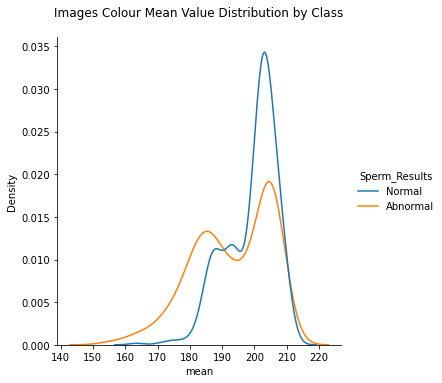

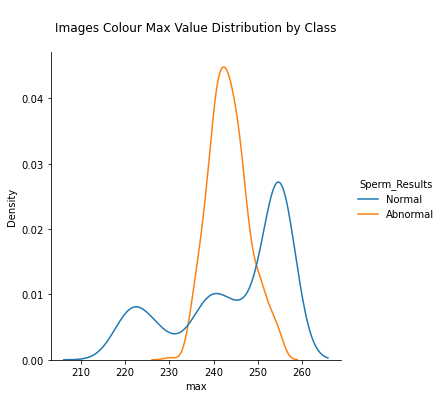

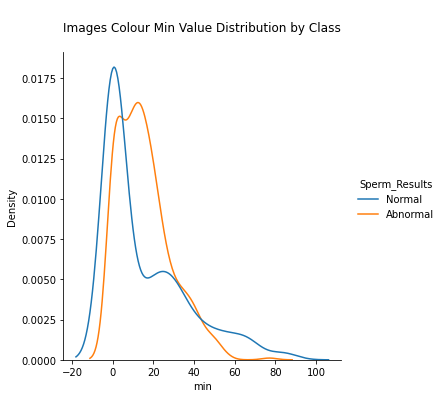

In [15]:
ax1 = sns.displot(data = imageEDA, x = 'mean', kind="kde", hue = 'Sperm_Results');
plt.title('Images Colour Mean Value Distribution by Class\n', fontsize = 12);

ax2 = sns.displot(data = imageEDA, x = 'max', kind="kde", hue = 'Sperm_Results');
plt.title('\nImages Colour Max Value Distribution by Class\n', fontsize = 12);

ax3 = sns.displot(data = imageEDA, x = 'min', kind="kde", hue = 'Sperm_Results');
plt.title('\nImages Colour Min Value Distribution by Class\n', fontsize = 12);

The Mean vs Density plot insights for pixels:
The max pixel value for Sperm Normal cases is greater than 0.030 and less than 0.035.
The max pixel value for Sperm Abnormal cases is greater than 0.004 & less than 0.006.

The Max vs Density plot insights for pixels:
The max pixel value for Sperm Normal cases is greater than 0.035 and less than 0.040.
The max pixel value for Sperm Abnormal cases is 0.005.

The Min vs Density plot insights for pixels:
The max pixel value for Sperm Normal cases is greater than 0.4.
The max pixel value for Sperm Abnormal cases is greater than 0.0 and less than 0.1.

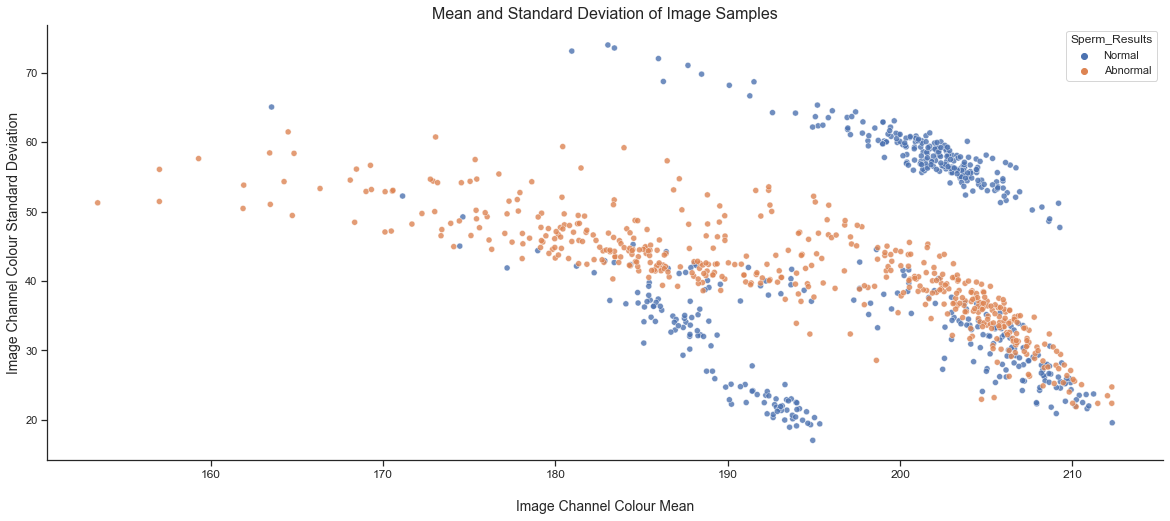

In [16]:
plt.figure(figsize = (20, 8))
sns.set(style = "ticks", font_scale = 1)
ax = sns.scatterplot(data = imageEDA, x = "mean", y = imageEDA['stedev'], hue = 'Sperm_Results', alpha = 0.8);
sns.despine(top = True, right = True, left = False, bottom = False)
plt.xticks(rotation = 0, fontsize = 12)
ax.set_xlabel('\nImage Channel Colour Mean', fontsize = 14)
ax.set_ylabel('Image Channel Colour Standard Deviation', fontsize = 14)
plt.title('Mean and Standard Deviation of Image Samples', fontsize = 16);


I observe that there are 2 clusters formed, one for Normal Sperm, one for Abnormal Sperm and both have few overlappings. Overlapping Color Mean range: (100 - 175)

I observe that for pixels having Std Deviation above 60 are all Normal Sperm images (Blue Colored). Below 20 are all Normal Sperm images

<Figure size 720x576 with 0 Axes>

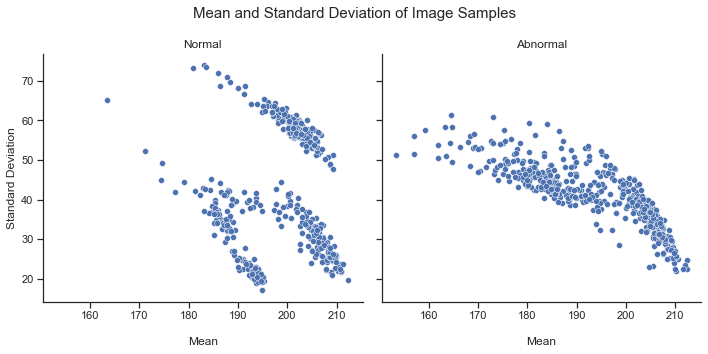

In [17]:
plt.figure(figsize = (10, 8));
g = sns.FacetGrid(imageEDA, col = "Sperm_Results", height = 5);
g.map_dataframe(sns.scatterplot, x = 'mean', y = 'stedev');
g.set_titles(col_template = "{col_name}", row_template= "{row_name}", size = 12);
g.fig.subplots_adjust(top = .7);
g.fig.suptitle('Mean and Standard Deviation of Image Samples', fontsize = 15);
axes = g.axes.flatten();
axes[0].set_ylabel('Standard Deviation');
for ax in axes:
    ax.set_xlabel('\nMean');
g.fig.tight_layout();

# Data Modeling

Pre-Process Data

In [18]:
INPUT_SIZE = 128
sperm_data = []

# Storing images and their labels into a list for further Train Test split

for i in range(len(data)):
    image = cv2.imread(data['path'][i])
    image = cv2.resize(image, (INPUT_SIZE, INPUT_SIZE)) / 255.0
    label = 0 if data['Sperm_Results'][i] == "Normal" else 1
    sperm_data.append([image, label])

In [19]:
data['Sperm_Results'][0]

'Normal'

In [20]:
label

1

Shuffle Data before Train-Test-Split

In [21]:
random.shuffle(sperm_data)

In [22]:
len(sperm_data)

986

Train Test Split

In [24]:
x = []
y = []

for image, label in sperm_data:
    x.append(image)
    y.append(label)

# Converting to Numpy Array    
x = np.array(x)
y = np.array(y)

train_ratio = 0.75
validation_ratio = 0.15
test_ratio = 0.10

# train is now 75% of the entire data set
# the _junk suffix means that we drop that variable completely
x_train, x_test, y_train, y_test = train_test_split(np.array(x),np.array(y), test_size=1 -train_ratio, random_state = 42)

# test is now 10% of the initial data set
# validation is now 15% of the initial data set
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio), random_state = 42) 


In [25]:
print(x_train.shape, x_test.shape, x_val.shape, y_train.shape, y_test.shape, y_val.shape)

(739, 128, 128, 3) (99, 128, 128, 3) (148, 128, 128, 3) (739,) (99,) (148,)


In [26]:
x[0]

array([[[0.76862745, 0.62352941, 0.88627451],
        [0.77254902, 0.65098039, 0.88627451],
        [0.79215686, 0.68235294, 0.89803922],
        ...,
        [0.85882353, 0.83921569, 0.8627451 ],
        [0.8627451 , 0.84313725, 0.86666667],
        [0.8627451 , 0.84313725, 0.86666667]],

       [[0.79607843, 0.71764706, 0.91764706],
        [0.80392157, 0.7372549 , 0.91372549],
        [0.81176471, 0.75294118, 0.91372549],
        ...,
        [0.8627451 , 0.84313725, 0.86666667],
        [0.85882353, 0.83921569, 0.8627451 ],
        [0.85882353, 0.83921569, 0.8627451 ]],

       [[0.8       , 0.77254902, 0.90588235],
        [0.81568627, 0.78823529, 0.91764706],
        [0.81960784, 0.8       , 0.91372549],
        ...,
        [0.8627451 , 0.84313725, 0.86666667],
        [0.85882353, 0.83921569, 0.8627451 ],
        [0.85882353, 0.83921569, 0.8627451 ]],

       ...,

       [[0.85490196, 0.84705882, 0.85882353],
        [0.85490196, 0.84705882, 0.85882353],
        [0.85490196, 0

In [27]:
y

array([1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0,
       0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0,
       1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1,
       1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1,
       0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0,
       0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0,
       1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0,
       0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0,

In [28]:
y_train[5]

1

# Encode the labels using LabelBinarizer

In [29]:
from sklearn.preprocessing import LabelBinarizer

lb=LabelBinarizer()

y_train=lb.fit_transform(y_train)
y_val=lb.fit_transform(y_val)
y_test=lb.fit_transform(y_test)

In [30]:
y_train[1]

array([0])

In [31]:
y_val[1]

array([0])

In [32]:
y_val[1]

array([0])

In [33]:
#training split
len(x_train)

739

In [34]:
#testing split
len(x_test)

99

In [35]:
# valuation split
len(x_val)

148

# Instantiate the Xception model

In [36]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.optimizers import Adam

In [37]:
IMAGE_SIZE = 128
# Defining the pretrained base model
base = Xception(include_top=False, weights='imagenet', input_shape=(IMAGE_SIZE,IMAGE_SIZE,3))

x = base.output
x = GlobalAveragePooling2D()(x)
# Defining the head of the model where the prediction is conducted
head = Dense(2)(x)
# Combining base and head 
xception_model = Model(inputs=base.input, outputs=head)

# Model summary

In [38]:
xception_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 63, 63, 32)   864         ['input_1[0][0]']                
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 63, 63, 32)  128         ['block1_conv1[0][0]']           
 ation)                                                                                           
                                                                                              

 n)                                                                                               
                                                                                                  
 block4_sepconv2 (SeparableConv  (None, 16, 16, 728)  536536     ['block4_sepconv2_act[0][0]']    
 2D)                                                                                              
                                                                                                  
 block4_sepconv2_bn (BatchNorma  (None, 16, 16, 728)  2912       ['block4_sepconv2[0][0]']        
 lization)                                                                                        
                                                                                                  
 conv2d_2 (Conv2D)              (None, 8, 8, 728)    186368      ['add_1[0][0]']                  
                                                                                                  
 block4_po

                                                                                                  
 block7_sepconv1_bn (BatchNorma  (None, 8, 8, 728)   2912        ['block7_sepconv1[0][0]']        
 lization)                                                                                        
                                                                                                  
 block7_sepconv2_act (Activatio  (None, 8, 8, 728)   0           ['block7_sepconv1_bn[0][0]']     
 n)                                                                                               
                                                                                                  
 block7_sepconv2 (SeparableConv  (None, 8, 8, 728)   536536      ['block7_sepconv2_act[0][0]']    
 2D)                                                                                              
                                                                                                  
 block7_se

                                                                  'add_6[0][0]']                  
                                                                                                  
 block10_sepconv1_act (Activati  (None, 8, 8, 728)   0           ['add_7[0][0]']                  
 on)                                                                                              
                                                                                                  
 block10_sepconv1 (SeparableCon  (None, 8, 8, 728)   536536      ['block10_sepconv1_act[0][0]']   
 v2D)                                                                                             
                                                                                                  
 block10_sepconv1_bn (BatchNorm  (None, 8, 8, 728)   2912        ['block10_sepconv1[0][0]']       
 alization)                                                                                       
          

 block12_sepconv3 (SeparableCon  (None, 8, 8, 728)   536536      ['block12_sepconv3_act[0][0]']   
 v2D)                                                                                             
                                                                                                  
 block12_sepconv3_bn (BatchNorm  (None, 8, 8, 728)   2912        ['block12_sepconv3[0][0]']       
 alization)                                                                                       
                                                                                                  
 add_10 (Add)                   (None, 8, 8, 728)    0           ['block12_sepconv3_bn[0][0]',    
                                                                  'add_9[0][0]']                  
                                                                                                  
 block13_sepconv1_act (Activati  (None, 8, 8, 728)   0           ['add_10[0][0]']                 
 on)      

In [39]:
from tensorflow.keras.optimizers import Nadam
opt = Nadam(learning_rate=1e-4, decay=1e-4)
xception_model.compile(loss='categorical_crossentropy',optimizer=opt,metrics=['accuracy'])

# Data Augmentation

In [40]:
# Use the Image Data Generator to import the images from the dataset
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   featurewise_center=True,
                                   rotation_range=20,
                                   shear_range = 0.2,
                                   #zoom_range = 0.2,
                                   validation_split=0.15,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [44]:
# Make sure you provide the same target size as initialied for the image size
BATCH_SIZE = 32
IMAGE_SIZE = 128
train_generator = train_datagen.flow_from_directory('Sperm-Data/all_data',
                                                 target_size = (IMAGE_SIZE, IMAGE_SIZE),
                                                 batch_size = BATCH_SIZE,
                                                 class_mode = 'categorical')

Found 986 images belonging to 2 classes.


In [45]:
validation_generator  = test_datagen.flow_from_directory('Sperm-Data/all_data',
                                            target_size = (IMAGE_SIZE, IMAGE_SIZE),
                                            batch_size = BATCH_SIZE,
                                            class_mode = 'categorical')

Found 986 images belonging to 2 classes.


(32, 128, 128, 3)


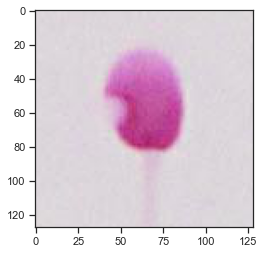

(32, 128, 128, 3)


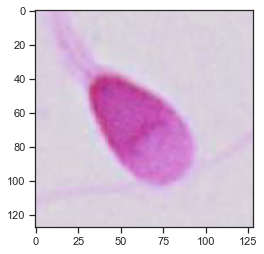

(32, 128, 128, 3)


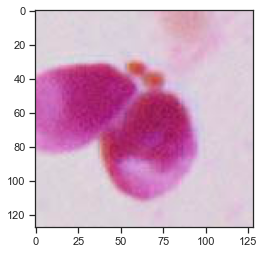

(32, 128, 128, 3)


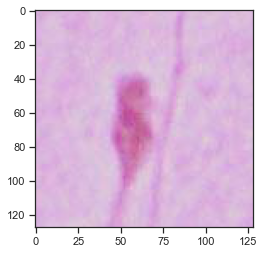

(32, 128, 128, 3)


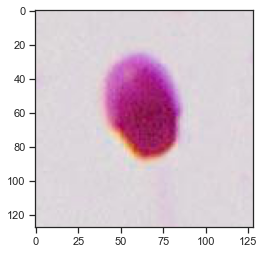

In [46]:
for _ in range(5):
    img, label = validation_generator.next()
    print(img.shape)   #  (32, 128, 128, 3)
    plt.imshow(img[0])
    plt.show()

In [47]:
train_generator.samples

986

In [48]:
validation_generator.samples

986

In [50]:
history = xception_model.fit(
  train_generator,
  validation_data=validation_generator,
  epochs=50,
  steps_per_epoch=len(train_generator),
  validation_steps=len(validation_generator)
)

C:\Users\sbhum\AppData\Roaming\Python\Python310\site-packages\keras\preprocessing\image.py:1863: UserWarning:

This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.



Epoch 1/50
31/31 [==============================] - 424s 12s/step - loss: 2.8174 - accuracy: 0.4280 - val_loss: 4.0349 - val_accuracy: 0.5974
Epoch 2/50
31/31 [==============================] - 398s 13s/step - loss: 2.1455 - accuracy: 0.4959 - val_loss: 2.8769 - val_accuracy: 0.5811
Epoch 3/50
31/31 [==============================] - 377s 12s/step - loss: 2.7655 - accuracy: 0.4716 - val_loss: 3.7525 - val_accuracy: 0.5639
Epoch 4/50
31/31 [==============================] - 334s 11s/step - loss: 2.3601 - accuracy: 0.4199 - val_loss: 3.4520 - val_accuracy: 0.5233
Epoch 5/50
31/31 [==============================] - 334s 11s/step - loss: 1.6242 - accuracy: 0.4807 - val_loss: 3.1227 - val_accuracy: 0.5639
Epoch 6/50
31/31 [==============================] - 328s 11s/step - loss: 1.5851 - accuracy: 0.4625 - val_loss: 2.6470 - val_accuracy: 0.5264
Epoch 7/50
31/31 [==============================] - 337s 11s/step - loss: 1.9784 - accuracy: 0.4655 - val_loss: 2.2161 - val_accuracy: 0.5091
Epoch 

# Checking with model

In [51]:
# Checking predictions for the above sample images
img_path = ['Sperm-Data/all_data/0/s12016a_99_99_2980_15887.png',
            'Sperm-Data/all_data/1/2017a_99_99_16626_3159.png',
            'Sperm-Data/all_data/0/s12015a_299_99_9497_40105.png',
            'Sperm-Data/all_data/0/s12015a_399_99_12119_9881.png',
            'Sperm-Data/all_data/0/s12015a_99_299_22868_8056.png',
            'Sperm-Data/all_data/0/s12015a_299_299_18769_9234.png'
           ]

for i in img_path:
    z_img = cv2.imread(i)
    z_img = cv2.resize(z_img, (128, 128)) / 255.0
    z_img = z_img.reshape(1, z_img.shape[0], z_img.shape[1], z_img.shape[2])
    
    z = xception_model.predict(z_img)
    z = np.argmax(z, axis = 1)
    print("Image", img_path.index(i) + 1, ":", z)

1/1 [==============================] - 4s 4s/step
Image 1 : [1]
1/1 [==============================] - 0s 200ms/step
Image 2 : [1]
1/1 [==============================] - 0s 159ms/step
Image 3 : [1]
1/1 [==============================] - 0s 109ms/step
Image 4 : [1]
1/1 [==============================] - 0s 106ms/step
Image 5 : [1]
1/1 [==============================] - 0s 99ms/step
Image 6 : [1]


# Save Model

In [52]:
# h5 is a serialization format
#xception_model.save('sperm_morphology_xception_model.h5')

# Reports

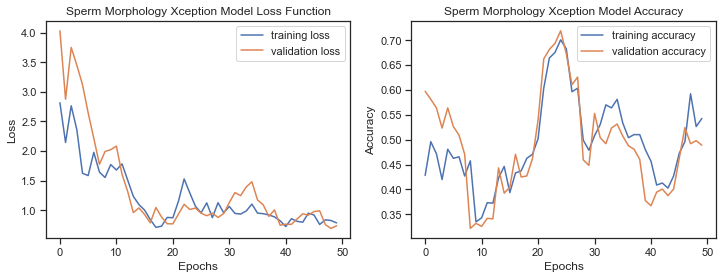

In [53]:
history_df = pd.DataFrame(history.history)

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history_df['loss'], label='training loss')
plt.plot(history_df['val_loss'], label='validation loss')
plt.title('Sperm Morphology Xception Model Loss Function')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1,2,2)
plt.plot(history_df['accuracy'], label='training accuracy')
plt.plot(history_df['val_accuracy'], label='validation accuracy')
plt.title('Sperm Morphology Xception Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
#plt.savefig('Results/Sperm-Morphology-Xception-Model-Accuracy-Loss.png')
plt.legend();

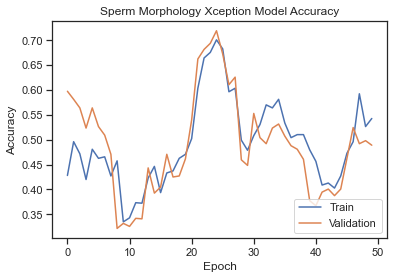

In [54]:
# Summarize History for Accuracy

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Sperm Morphology Xception Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'lower right')
plt.show()
#plt.savefig('Results/Xception-Sperm-Accuracy-Comparison.png')

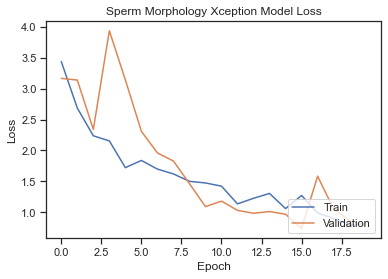

In [74]:
# Summarize History for Loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Sperm Morphology Xception Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'lower right')
plt.show()
#plt.savefig('Results/Xception-Sperm-Loss-Comparison.png')

In [75]:
yp_train = xception_model.predict(x_train)
yp_train = np.argmax(yp_train, axis = 1)

yp_val = xception_model.predict(x_val)
yp_val = np.argmax(yp_val, axis = 1)

yp_test = xception_model.predict(x_test)
yp_test = np.argmax(yp_test, axis = 1)

8/8 [==============================] - 4s 473ms/step


# Predicting Sperm Test Dataset

In [58]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Predicting labels from X_test data
y_pred = xception_model.predict(x_test)

# Converting prediction classes from one hot encoding to list
# Argmax returns the position of the largest value
y_pred_classes = np.argmax(y_pred)

# Convert test labels from one hot encoding to list
y_test_classes = np.argmax(y_test)

# https://www.v7labs.com/blog/confusion-matrix-guide

# Create the confusion matrix
confmx = confusion_matrix(y_test_classes, y_pred_classes)
f, ax = plt.subplots(figsize = (8,8))
sns.heatmap(confmx, annot=True, fmt='.1f', xticklabels='auto', yticklabels='auto')
plt.xlabel('Predicted Sperm Labels')
plt.ylabel('True Sperm Labels')
plt.title('Xception Model - Sperm Testset Confusion Matrix')
#plt.savefig('Results/Sperm-Morphology-Xception-Model-Confusion-Matrix.png')
plt.show();

7/7 [==============================] - 3s 411ms/step


TypeError: Singleton array 0 cannot be considered a valid collection.

In [56]:
# Printing the model scores:
print(classification_report(y_test_classes, y_pred_classes))

NameError: name 'y_test_classes' is not defined

In [59]:
y_train_arg=np.argmax(y_train,axis=1)
yp_train = np.argmax(xception_model.predict(x_train),axis=1)
print('Train Confusion Matrix')
print(confusion_matrix(y_train_arg, yp_train))

AxisError: axis 1 is out of bounds for array of dimension 1

In [66]:
y_val_arg=np.argmax(y_val,axis=1)
yp_val = np.argmax(xception_model.predict(x_val),axis=1)
print('Val Confusion Matrix')
print(confusion_matrix(y_val_arg, yp_val))

3/3 [==============================] - 1s 341ms/step
Val Confusion Matrix
[[73  1]
 [ 0  0]]


In [67]:
y_test_arg=np.argmax(y_test,axis=1)
yp_test = np.argmax(xception_model.predict(x_test),axis=1)
print('Confusion Matrix')
print(confusion_matrix(y_test_arg, yp_test))

8/8 [==============================] - 4s 463ms/step
Confusion Matrix
[[240   7]
 [  0   0]]


# Model Evaluation

In [60]:
def evaluation_parametrics(name, y_train_arg, yp_train, y_val_arg, yp_val, y_test_arg, yp_test):
    
    print("\n-----------------------------{}-----------------------------\n".format(name))
    
    cm_train = confusion_matrix(y_train_arg, yp_train)
    t1 = ConfusionMatrixDisplay(cm_train)
    s1 = round((cm_train[0,0]/(cm_train[0,0] + cm_train[0,1])),4)
    
    print("Classification Report for Train Data\n")
    print(classification_report(y_train_arg, yp_train)) 
    print("--------------------------------------------------------------------------")
    print("Recall on Train Data: ", round(recall_score(y_train_arg, yp_train, average='micro'),4))
    print("Specificity on Train Data: ", s1)
    print("Accuracy on Train Data: ", round(accuracy_score(y_train_arg, yp_train),4))
    print("Precision on Train Data: ", round(precision_score(y_train_arg, yp_train, average='micro'),4))
    print("F1 Score on Train Data: ", round(f1_score(y_train_arg, yp_train, average='micro'),4))
    #print("ROC AUC Score on Train Data: ", round(roc_auc_score(y_train_arg, yp_train,average='micro'),4))
    print("--------------------------------------------------------------------------")
    
    
    cm_val = confusion_matrix(y_val_arg, yp_val)
    t2 = ConfusionMatrixDisplay(cm_val)
    s2 = round((cm_val[0,0]/(cm_val[0,0] + cm_val[0,1])),4)
    
    print("\nClassification Report for Validation Data\n")
    print(classification_report(y_val_arg, yp_val))   
    print("--------------------------------------------------------------------------")
    print("Recall on Val Data: ", round(recall_score(y_val_arg, yp_val, average='micro'),4))
    print("Specificity on Val Data: ", s2)
    print("Accuracy on Val Data: ", round(accuracy_score(y_val_arg, yp_val),4))
    print("Precision on Val Data: ", round(precision_score(y_val_arg, yp_val, average='micro'),4))
    print("F1 Score on Val Data: ", round(f1_score(y_val_arg, yp_val, average='micro'),4))
    print("--------------------------------------------------------------------------")


    cm_test = confusion_matrix(y_test_arg, yp_test)
    t3 = ConfusionMatrixDisplay(cm_test)
    s3 = round((cm_test[0,0]/(cm_test[0,0] + cm_test[0,1])),4)
    
    print("\nClassification Report for Test Data\n")
    print(classification_report(y_test_arg, yp_test))   
    print("--------------------------------------------------------------------------")
    print("Recall on Test Data: ", round(recall_score(y_test_arg, yp_test, average='micro'), 4))
    print("Specificity on Test Data: ", s3)
    print("Accuracy on Test Data: ", round(accuracy_score(y_test_arg, yp_test), 4))
    print("Precision on Test Data: ", round(precision_score(y_test_arg, yp_test, average='micro'), 4))
    print("F1 Score Test Data: ", round(f1_score(y_test_arg, yp_test, average='micro'), 4))
    print("--------------------------------------------------------------------------")
    
    t1.plot()
    t2.plot()
    t3.plot()

In [63]:
def evaluation_parametrics(name, y_train, yp_train, y_val, yp_val, y_test, yp_test):
    
    print("\n-----------------------------{}-----------------------------\n".format(name))
    
    cm_train = confusion_matrix(y_train, yp_train)
    t1 = ConfusionMatrixDisplay(cm_train)
    s1 = round((cm_train[0,0]/(cm_train[0,0] + cm_train[0,1])),4)
    
    print("Classification Report for Train Data\n")
    print(classification_report(y_train, yp_train)) 
    print("--------------------------------------------------------------------------")
    print("Recall on Train Data: ", round(recall_score(y_train, yp_train),4))
    print("Specificity on Train Data: ", s1)
    print("Accuracy on Train Data: ", round(accuracy_score(y_train, yp_train),4))
    print("Precision on Train Data: ", round(precision_score(y_train, yp_train),4))
    print("F1 Score on Train Data: ", round(f1_score(y_train, yp_train),4))
    print("--------------------------------------------------------------------------")
       
    cm_val = confusion_matrix(y_val, yp_val)
    t2 = ConfusionMatrixDisplay(cm_val)
    s2 = round((cm_val[0,0]/(cm_val[0,0] + cm_val[0,1])),4)
    
    print("\nClassification Report for Validation Data\n")
    print(classification_report(y_val, yp_val))   
    print("--------------------------------------------------------------------------")
    print("Recall on Val Data: ", round(recall_score(y_val, yp_val),4))
    print("Specificity on Val Data: ", s2)
    print("Accuracy on Val Data: ", round(accuracy_score(y_val, yp_val),4))
    print("Precision on Val Data: ", round(precision_score(y_val, yp_val),4))
    print("F1 Score on Val Data: ", round(f1_score(y_val, yp_val),4))
    print("--------------------------------------------------------------------------")

    cm_test = confusion_matrix(y_test, yp_test)
    t3 = ConfusionMatrixDisplay(cm_test)
    s3 = round((cm_test[0,0]/(cm_test[0,0] + cm_test[0,1])),4)
    
    print("\nClassification Report for Test Data\n")
    print(classification_report(y_test, yp_test))   
    print("--------------------------------------------------------------------------")
    print("Recall on Test Data: ", round(recall_score(y_test, yp_test), 4))
    print("Specificity on Test Data: ", s3)
    print("Accuracy on Test Data: ", round(accuracy_score(y_test, yp_test), 4))
    print("Precision on Test Data: ", round(precision_score(y_test, yp_test), 4))
    print("F1 Score Test Data: ", round(f1_score(y_test, yp_test), 4))
    print("--------------------------------------------------------------------------")
    
    t1.plot()
    t2.plot()   
    t3.plot()


-----------------------------Convolution Neural Network-----------------------------

Classification Report for Train Data

              precision    recall  f1-score   support

           0       0.37      0.30      0.33       375
           1       0.34      0.41      0.37       334

    accuracy                           0.35       709
   macro avg       0.36      0.36      0.35       709
weighted avg       0.36      0.35      0.35       709

--------------------------------------------------------------------------
Recall on Train Data:  0.4102
Specificity on Train Data:  0.304
Accuracy on Train Data:  0.354
Precision on Train Data:  0.3442
F1 Score on Train Data:  0.3743
--------------------------------------------------------------------------

Classification Report for Validation Data

              precision    recall  f1-score   support

           0       0.33      0.39      0.35        36
           1       0.39      0.33      0.35        43

    accuracy                  

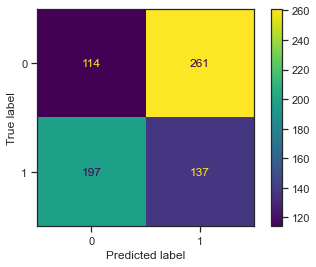

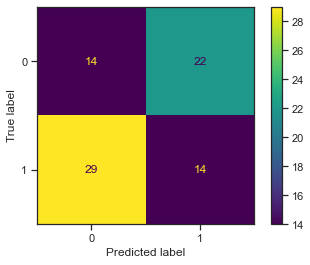

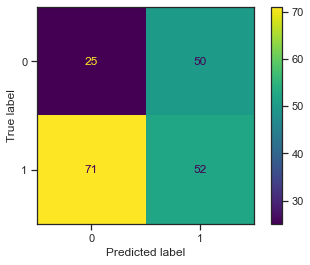

In [64]:
evaluation_parametrics("Convolution Neural Network", y_train, yp_train, y_val, yp_val, y_test, yp_test)

Checking with Model

In [95]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, recall_score, accuracy_score, precision_score, f1_score

In [65]:
evaluation_parametrics("Sperm Morphology Xception Neural Network", y_train_arg, yp_train, y_val_arg, yp_val, y_test_arg, yp_test)

NameError: name 'y_train_arg' is not defined

In [71]:
# list all data in history

print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [76]:
from sklearn.metrics import roc_curve

y_pred_keras = xception_model.predict(x_test).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)

8/8 [==============================] - 4s 455ms/step


ValueError: Found input variables with inconsistent numbers of samples: [247, 494]

In [79]:
y_test.shape[0]

247

In [80]:
y_pred_keras.shape[0]

494

ROC-AUC Analysis

In [81]:
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
import sklearn.metrics as metrics
#predict proba
y_proba = xception_model.predict_on_batch(x_test)

In [82]:
micro_roc_auc_ovr = roc_auc_score(
    y_test,
    y_proba,
    multi_class="ovr",
    average="micro",
)
micro_roc_auc_ovr

ValueError: y should be a 1d array, got an array of shape (247, 2) instead.

# Image Analysis using Grad-CAM

In [97]:
def plot_multiple_img(img_matrix_list, title_list, ncols, main_title = ""):
    
    fig, myaxes = plt.subplots(figsize = (15, 8), nrows = 2, ncols = ncols, squeeze = False)
    fig.suptitle(main_title, fontsize = 18)
    fig.subplots_adjust(wspace = 0.3)
    fig.subplots_adjust(hspace = 0.3)
    
    for i, (img, title) in enumerate(zip(img_matrix_list, title_list)):
        myaxes[i // ncols][i % ncols].imshow(img)
        myaxes[i // ncols][i % ncols].set_title(title, fontsize = 15)
        
    plt.savefig('Results/Xception-Day5-Embryos-Testset-Images-Heatmap-Analysis.png')
    plt.show()

Config- Parameters

In [114]:
# Grad-CAM

import keras
import matplotlib.cm as cm

model_builder = keras.applications.xception.Xception
img_size = (299, 299)
preprocess_input = keras.applications.xception.preprocess_input
decode_predictions = keras.applications.xception.decode_predictions
imag = []

last_conv_layer_name = "block14_sepconv2_act"

# Reading 2 Covid & 2 Normal Images for Grad-Cam Analysis

img_path = ['Sperm-Data/all_data/0/s12016a_99_99_2980_15887.png',
            'Sperm-Data/all_data/1/2017a_99_99_16626_3159.png'
           ]

Grad - CAM Algorithm

In [115]:
# To Get Image into numpy array


def get_img_array(img_path, size):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size = size) 
    array = tf.keras.preprocessing.image.img_to_array(img) 
    array = np.expand_dims(array, axis = 0)
    return array

# Top create heatmaps for the samples

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index = None):
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(last_conv_layer_name).output, model.output])

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# Heatmap

In [116]:
# Storing Heatmap values into list

Xception_sperm_heatmap = []

for i in img_path:
    img_array = preprocess_input(get_img_array(i, size = img_size))
    model = model_builder(weights = "imagenet")
    model.layers[-1].activation = None
    preds = model.predict(img_array)
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
    Xception_sperm_heatmap.append(heatmap)

1/1 [==============================] - 1s 860ms/step


Creating a Superimposed Viz

In [117]:
# To Display GradCAM output for the samples

def save_and_display_gradcam(img_path, heatmap, cam_path = "cam.jpg", alpha = 0.4):
    img = tf.keras.preprocessing.image.load_img(img_path)
    img = tf.keras.preprocessing.image.img_to_array(img)

    heatmap = np.uint8(255 * heatmap)

    jet = cm.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)
    superimposed_img.save(cam_path)
    
    imag.append(cv2.imread(img_path))
    imag.append(cv2.imread("./cam.jpg"))


for i in range(len(img_path)):
    save_and_display_gradcam(img_path[i], Xception_sperm_heatmap[i])

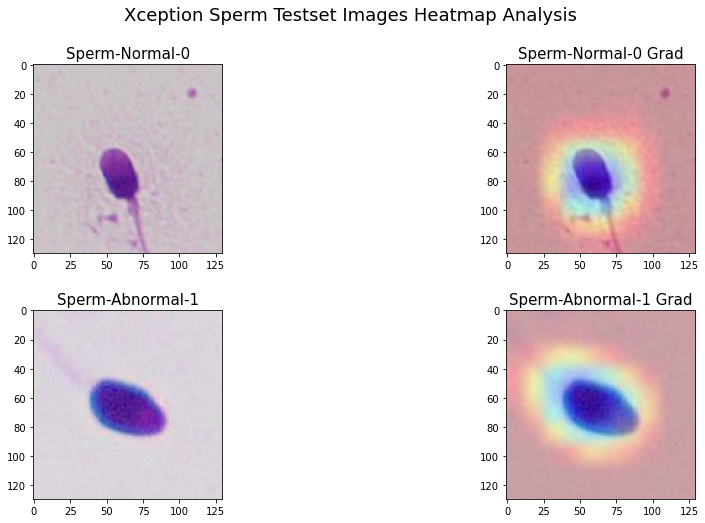

In [118]:
titles_list = ['Sperm-Normal-0', 'Sperm-Normal-0 Grad','Sperm-Abnormal-1', 'Sperm-Abnormal-1 Grad']
plot_multiple_img(imag, titles_list, ncols = 2, main_title = "Xception Sperm Testset Images Heatmap Analysis")

# Test the Xception Model

In [76]:
#load model
from keras.models import load_model
model=load_model("sperm_morphology_xception_model.h5")

In [77]:
classes = [0, 1]
IMG_SIZE = 128

def sperm_predict(imgfilepath):
    
    img_array = cv2.imread(imgfilepath)
    new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE) )
    # Normalizing the image
    image=new_array/255.0
    prediction = model.predict([image.reshape(-1, IMG_SIZE, IMG_SIZE, 3)])
    MaxPosition=np.argmax(prediction)  
    prediction_label=classes[MaxPosition]
    
    if prediction_label == 0:
        return "Normal Sperm"
    elif prediction_label == 1:
        return "Abnormal Sperm"
    

In [82]:
sperm_predict('Sperm-Data/all_data/1/2017a_99_99_11286_4385.png')

1/1 [==============================] - 0s 83ms/step


'Abnormal Sperm'

In [91]:
sperm_predict('Sperm-Data/all_data/1/2017a_99_99_18497_6672.png')

1/1 [==============================] - 0s 80ms/step


'Abnormal Sperm'

In [83]:
sperm_predict('Sperm-Data/all_data/0/s12015a_299_299_19913_9805.png')

1/1 [==============================] - 0s 119ms/step


'Normal Sperm'

In [88]:
sperm_predict('Sperm-Data/all_data/0/2017b_99_99_22114_5907.png')

1/1 [==============================] - 0s 96ms/step


'Normal Sperm'